In [1]:
import pandas as pd
import numpy as np
import re, string
import nltk.corpus

from tqdm import tqdm

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, cross_validate, train_test_split
from sklearn.metrics import f1_score, recall_score

In [2]:
train = pd.read_csv('../quora-insincere-questions-classification/train.csv')
train.head(3)

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0


In [3]:
test = pd.read_csv('../quora-insincere-questions-classification/test.csv')
test.head(3)

,qid,question_text
0,0000163e3ea7c7a74cd7,Why do so many women become so rude and arroga...
1,00002bd4fb5d505b9161,When should I apply for RV college of engineer...
2,00007756b4a147d2b0b3,What is it really like to be a nurse practitio...


In [4]:
train.isnull().sum()

qid              0
question_text    0
target           0
dtype: int64

In [5]:
# cleaning the data
nltk.download('stopwords')
nltk.download('wordnet') 
nltk.download('omw-1.4')
stop = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
def clean_text(text):
    text = text.lower()
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", text)
    text = nopunct.split(' ')
    text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", str(text)) # remove unicode characters
    text = re.sub(r'[^a-zA-Z\s]+', '', text)
    text = ' '.join([word for word in text.split(' ') if word not in stop]) # remove stop words
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split(' ')]) # lemmatization
    text = re.sub(' +', ' ', text) # remove extra spaces
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\joensbj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\joensbj\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\joensbj\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [6]:
# tqdm.pandas()
# train_clean = train
# train_clean['clean_text'] = train['question_text'].progress_apply(clean_text)

In [7]:
# if you have already saved the cleaned strings you can start from here
train_clean = pd.read_csv('../quora-insincere-questions-classification/train_clean.csv')
train_clean.head()

,Unnamed: 0,qid,question_text,target,clean_text
0,0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,quebec nationalist see province nation
1,1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,adopted dog would encourage people adopt shop
2,2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,velocity affect time velocity affect space geo...
3,3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,otto von guericke used magdeburg hemisphere
4,4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,convert montra helicon mountain bike changing ...


In [8]:
train['question_text'].iloc[0]

'How did Quebec nationalists see their province as a nation in the 1960s?'

In [9]:
train_clean['clean_text'].iloc[0]

'quebec nationalist see province nation '

In [10]:
# train_clean.to_csv('../quora-insincere-questions-classification/train_clean.csv')

In [11]:
train_clean = train_clean[['clean_text','target']]
train_clean.head(3)

,clean_text,target
0,quebec nationalist see province nation,0
1,adopted dog would encourage people adopt shop,0
2,velocity affect time velocity affect space geo...,0


In [12]:
(X_train,X_test,y_train,y_test) = train_test_split(train_clean['clean_text'],train_clean['target'],train_size=0.8,stratify=train_clean['target'])
X_train.head(3)

783074    citizen hawaii wish become part failed state k...
854352     space really expanding platform thing expanding 
643988                                          zinc found 
Name: clean_text, dtype: object

In [13]:
vectorizer = TfidfVectorizer(analyzer='word', stop_words='english')
X_train = vectorizer.fit_transform(X_train.astype('U'))
X_test = vectorizer.transform(X_test.astype('U'))
X_train

<1044897x149039 sparse matrix of type '<class 'numpy.float64'>'
	with 5811379 stored elements in Compressed Sparse Row format>

In [14]:
X_train.shape

(1044897, 149039)

In [15]:
# train on a smaller set of the training data to reduce time as 1044897 is a lot of entries
sample_size = round(X_train.shape[0]/100)
X_sample = X_train[0:sample_size]
y_sample = y_train[0:sample_size]

C:\Users\joensbj\AppData\Local\Temp\ipykernel_12896\682099898.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_sample = y_train[0:sample_size]


In [16]:
knn = KNeighborsClassifier()
knnCV = cross_validate(knn,X_sample,y_sample)

In [17]:
knnCV['test_score'].mean()

0.9428653621956891

In [18]:
grid = {'n_neighbors':np.arange(1,50)}
gridCV = GridSearchCV(KNeighborsClassifier(),param_grid=grid,n_jobs=-1)
gridCV.fit(X_sample,y_sample)

GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])})

In [19]:
print(gridCV.best_score_)
print(gridCV.best_params_)

0.9437265604064123
{'n_neighbors': 7}


<AxesSubplot: xlabel='n neighbors'>

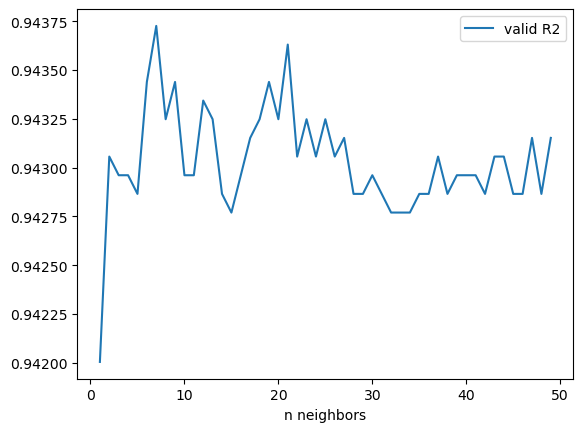

In [20]:
gridCV_results = pd.DataFrame()
gridCV_results['n neighbors'] = grid['n_neighbors']
gridCV_results['valid R2'] = gridCV.cv_results_['mean_test_score']
gridCV_results.plot(x='n neighbors',y='valid R2')

In [22]:
bestKNN = KNeighborsClassifier(n_neighbors=7)
bestKNN.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=7)

In [23]:
# bestKNN.score(X_test,y_test)

In [21]:
def predict(classifier, X_train, y_train, X_test, y_test):
    result = []
    predict_df = pd.DataFrame()
    classifier.fit(X_train, y_train)
    predicted = classifier.predict(X_test)
    predict_df = predicted

    recall = recall_score(y_test[y_test != -1], predicted[y_test != -1],
                              average="weighted")
    f1 = f1_score(y_test[y_test != -1], predicted[y_test != -1],
                      average="weighted")
    result.append([recall.mean(), f1.mean()])
    return result

In [ ]:
knn = KNeighborsClassifier()
predict(knn, X_sample, y_sample, X_test, y_test)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=7)
predict(knn, X_sample, y_sample, X_test, y_test)